In [42]:
%matplotlib inline
import glob
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps, ImageFilter
from scipy.ndimage.filters import laplace, generic_filter
from scipy.ndimage import (gaussian_gradient_magnitude, sobel,
                           maximum_filter, gaussian_laplace)

from numpy.lib.stride_tricks import as_strided

## exploring the data

In [36]:
def load(file):
    img = Image.open(file).convert('L')
    return np.array(img)

In [37]:
data_source = '/net/people/plgmatisz/antibodies/data/original/'

classes_to_load = {
    'ZIA': 'ziarnisty',
    'HOM': 'homogenous'
}

files = {key: glob.glob(f'{data_source}/{dir_}/*') for key, dir_ in classes_to_load.items()}

for k, v in files.items():
    print(f'{k}: {len(v)}')

ZIA: 492
HOM: 70


In [129]:
def grid_plot(arr, rows, cols, method='imshow', **kwargs):
    plots_count = rows * cols
    for plot_id, data in enumerate(arr[:plots_count]):
        plt.subplot(rows, cols, plot_id + 1)
        plt.__dict__[method](data, **kwargs)

ZIA examples


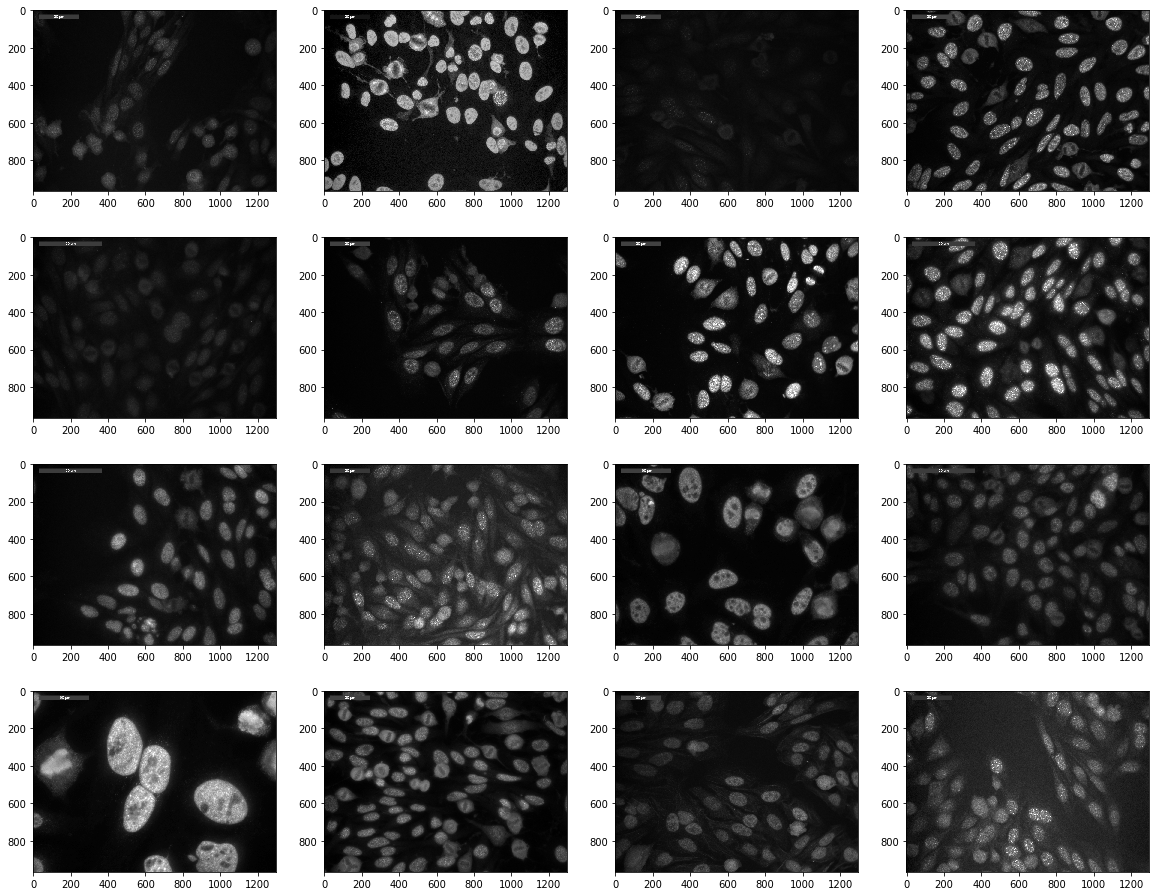

In [132]:
zia_examples = [load(f) for f in files['ZIA'][:50]]

print('ZIA examples')

plt.figure(figsize=(20, 16))
grid_plot(zia_examples, 4, 4, method='imshow', cmap='gray')

HOM examples


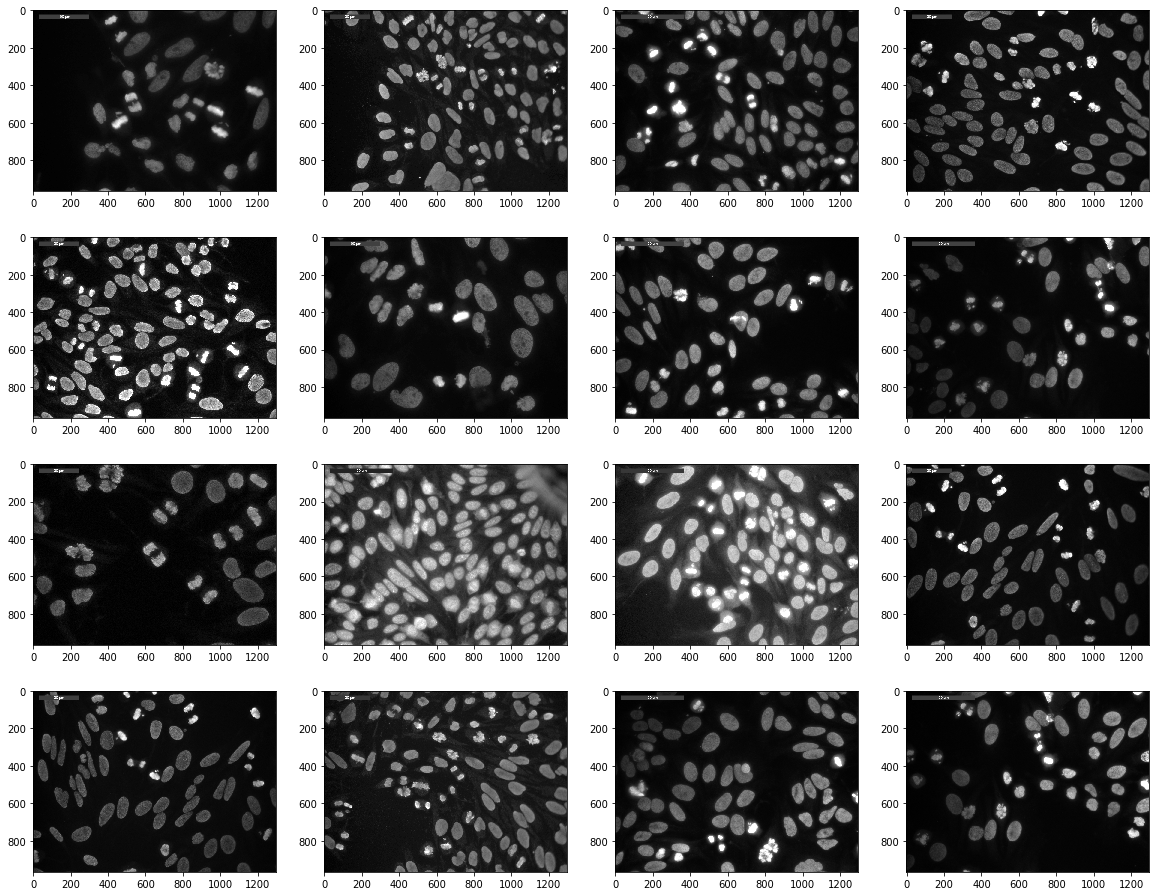

In [41]:
hom_examples = [load(f) for f in files['HOM'][:50]]

print('HOM examples')

plt.figure(figsize=(20, 16))
grid_plot(hom_examples, 4, 4, cmap='gray')

## standardizing images

In [94]:
def preprocess(img, size=(1200, 900)):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
        
    img = img.resize(size)
#     img = img.filter(ImageFilter.GaussianBlur(radius=5))
#     img = ImageOps.equalize(img)
    return np.array(img)

CPU times: user 372 ms, sys: 0 ns, total: 372 ms
Wall time: 369 ms


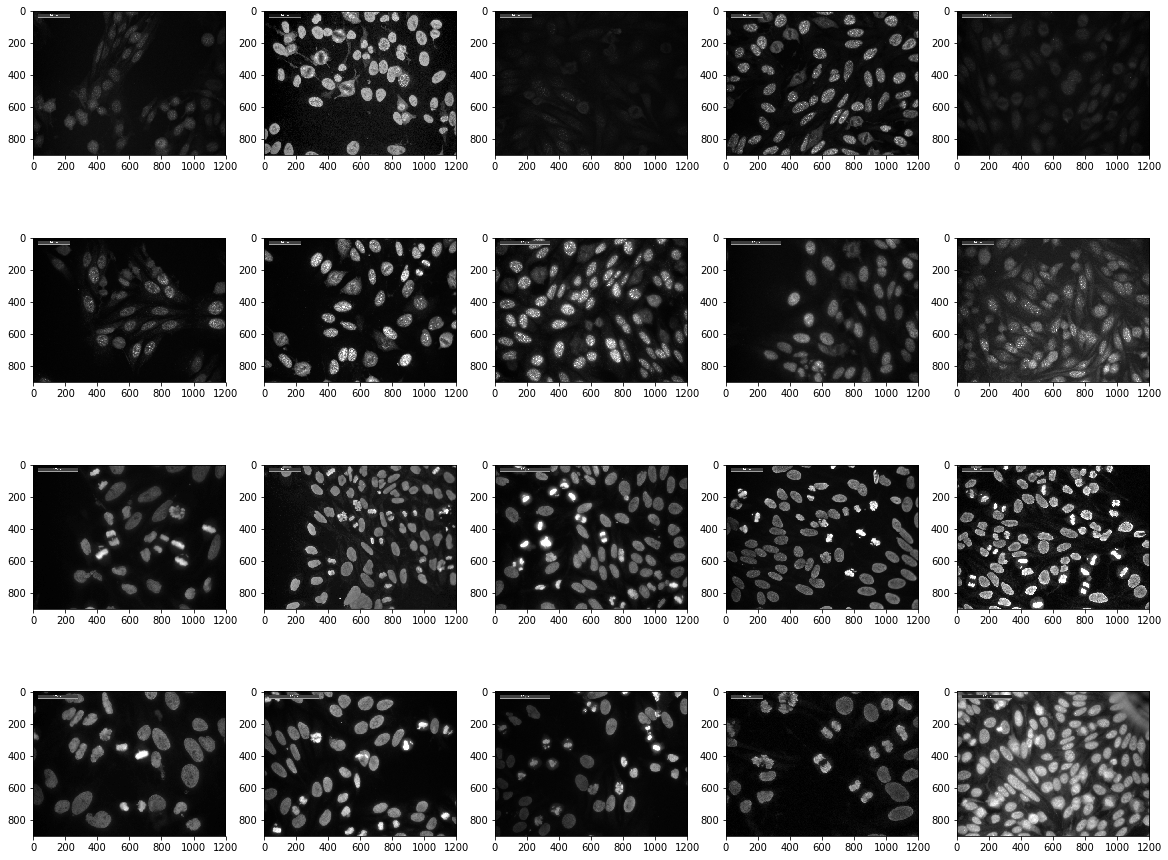

In [95]:
%%time
samples = zia_examples[:10] + hom_examples[:10]
samples = [preprocess(s) for s in samples]

plt.figure(figsize=(20, 16))
grid_plot(samples, 4, 5, cmap='gray')

## detecting ROI (regions of interest)

In [191]:
def to_windowed(arr, window_size, stride, flatten=True):
    arr_h, arr_w = arr.shape[:2]
    res_h = (arr_h - window_size) // stride + 1
    res_w = (arr_w - window_size) // stride + 1
    
    res = np.zeros((res_h, res_w, window_size, window_size))
    if flatten:
        res = res.reshape(res_h, res_w, -1)
        
    for h in range(res_h):
        for w in range(res_w):
            h_start = h * stride
            h_end = h * stride + window_size
            w_start = w * stride
            w_end = w * stride + window_size
            
            window = arr[h_start:h_end, w_start:w_end]
            if flatten:
                window = window.reshape(-1)
            res[h, w] = window
            
    return res

def resize_binary_mask(mask, target_size):
    mask = Image.fromarray(mask)
    mask = mask.resize(target_size)
    return np.array(mask)

CPU times: user 4.65 s, sys: 1.42 s, total: 6.07 s
Wall time: 6.05 s


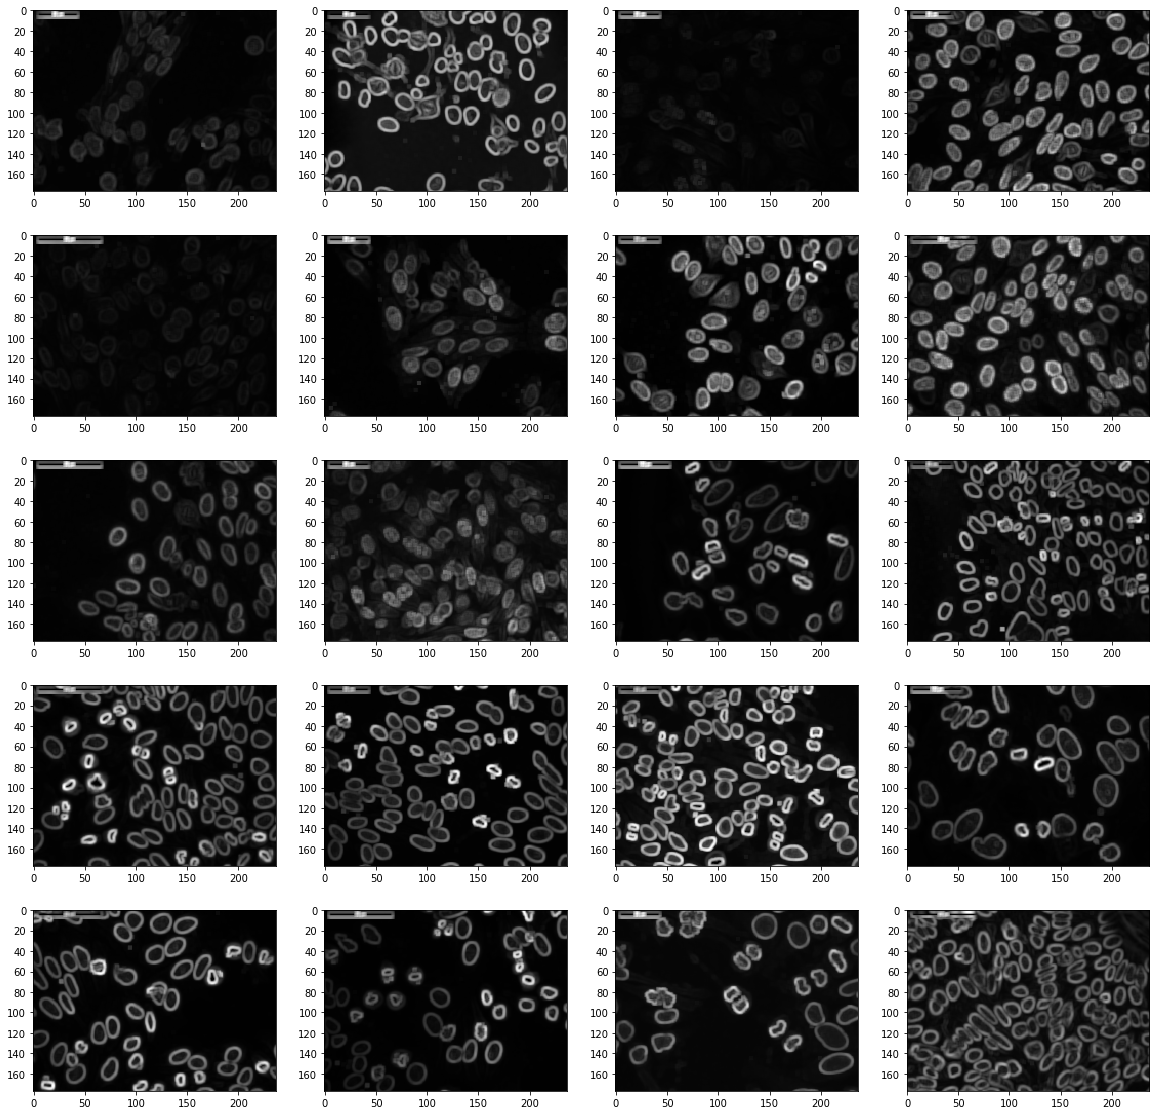

In [146]:
%%time

samples_std = []
std_th = 1.5
window_size = 20
stride = 5

for s in samples:
    s_windowed = to_windowed(s, window_size=window_size, stride=stride)
    s_std = np.std(s_windowed, axis=2)
    samples_std.append(s_std)
    
    
plt.figure(figsize=(20, 20))
grid_plot(samples_std, 5, 4, 'imshow', cmap='gray')

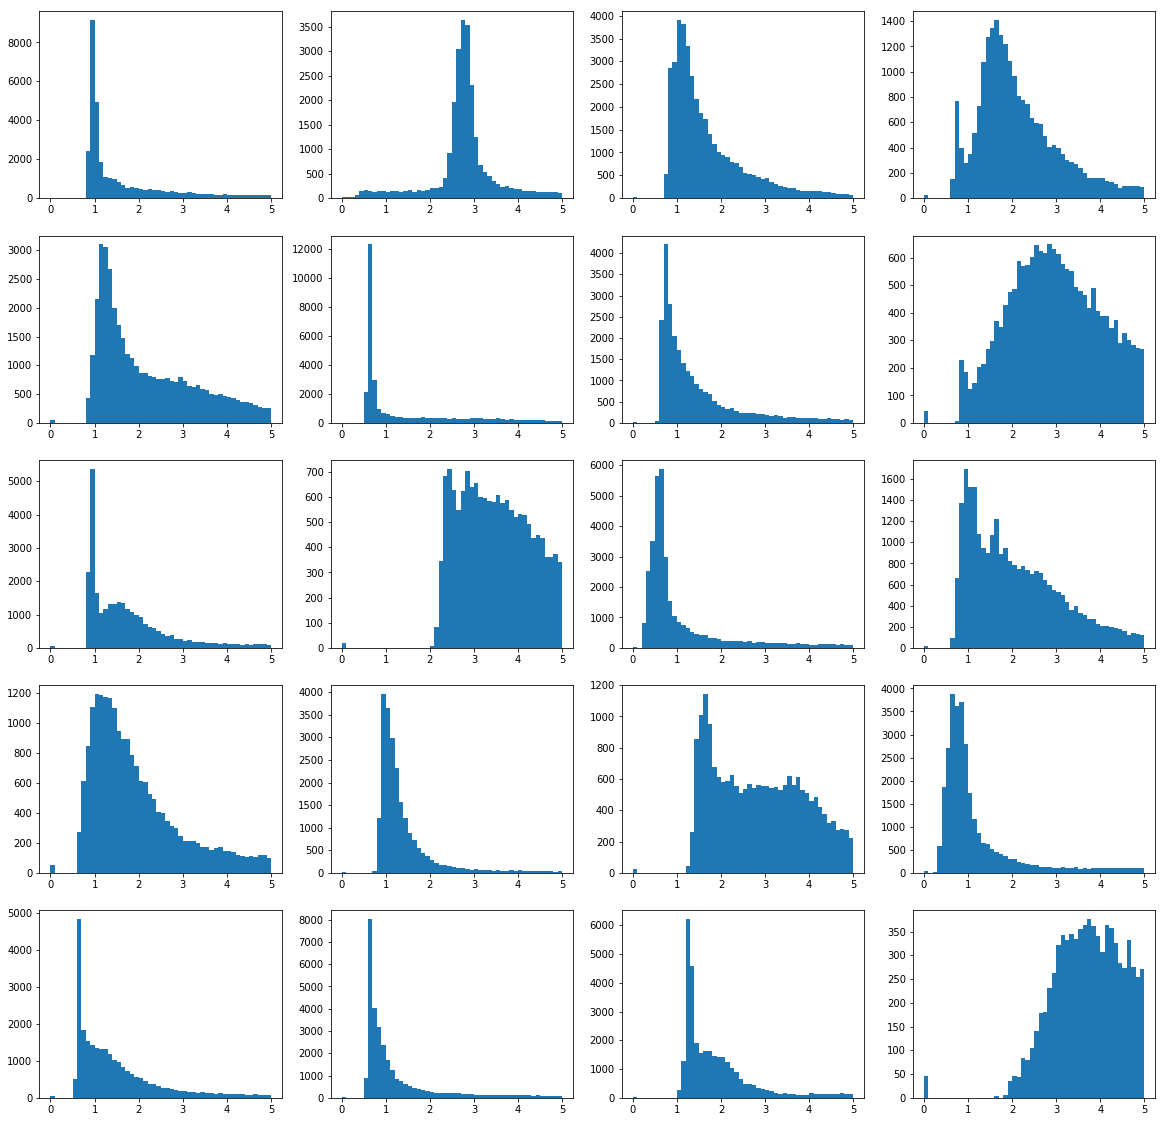

In [147]:
flattened_std = [s.reshape(-1) for s in samples_std]

plt.figure(figsize=(20, 20))
grid_plot(flattened_std, 5, 4, 'hist', bins=50, range=(0, 5))

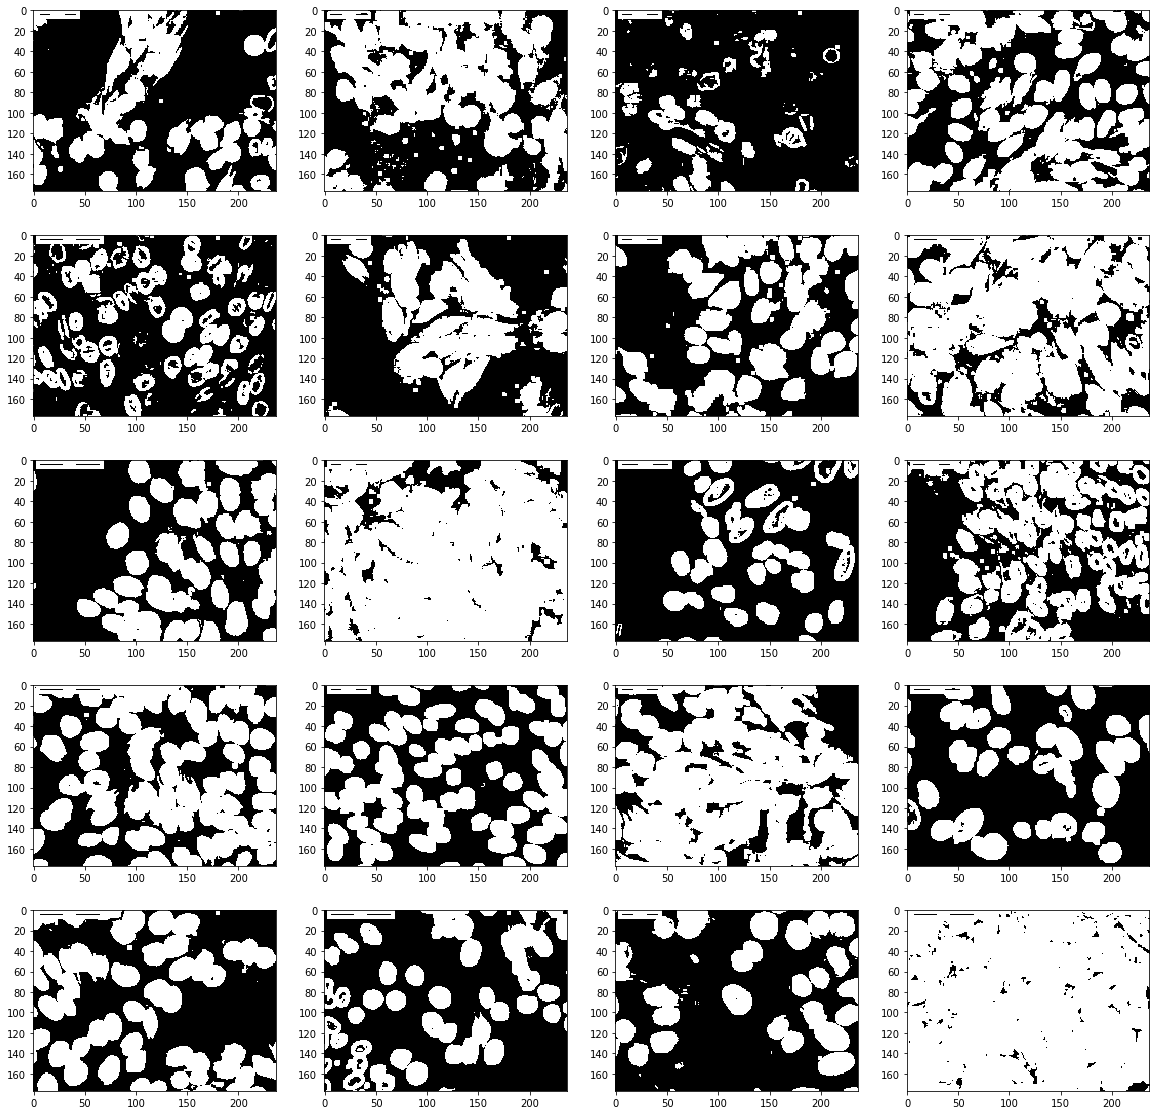

In [176]:
std_th = 3
std_masks = [s > std_th for s in samples_std]

plt.figure(figsize=(20, 20))
grid_plot(std_masks, 5, 4, 'imshow', cmap='gray')

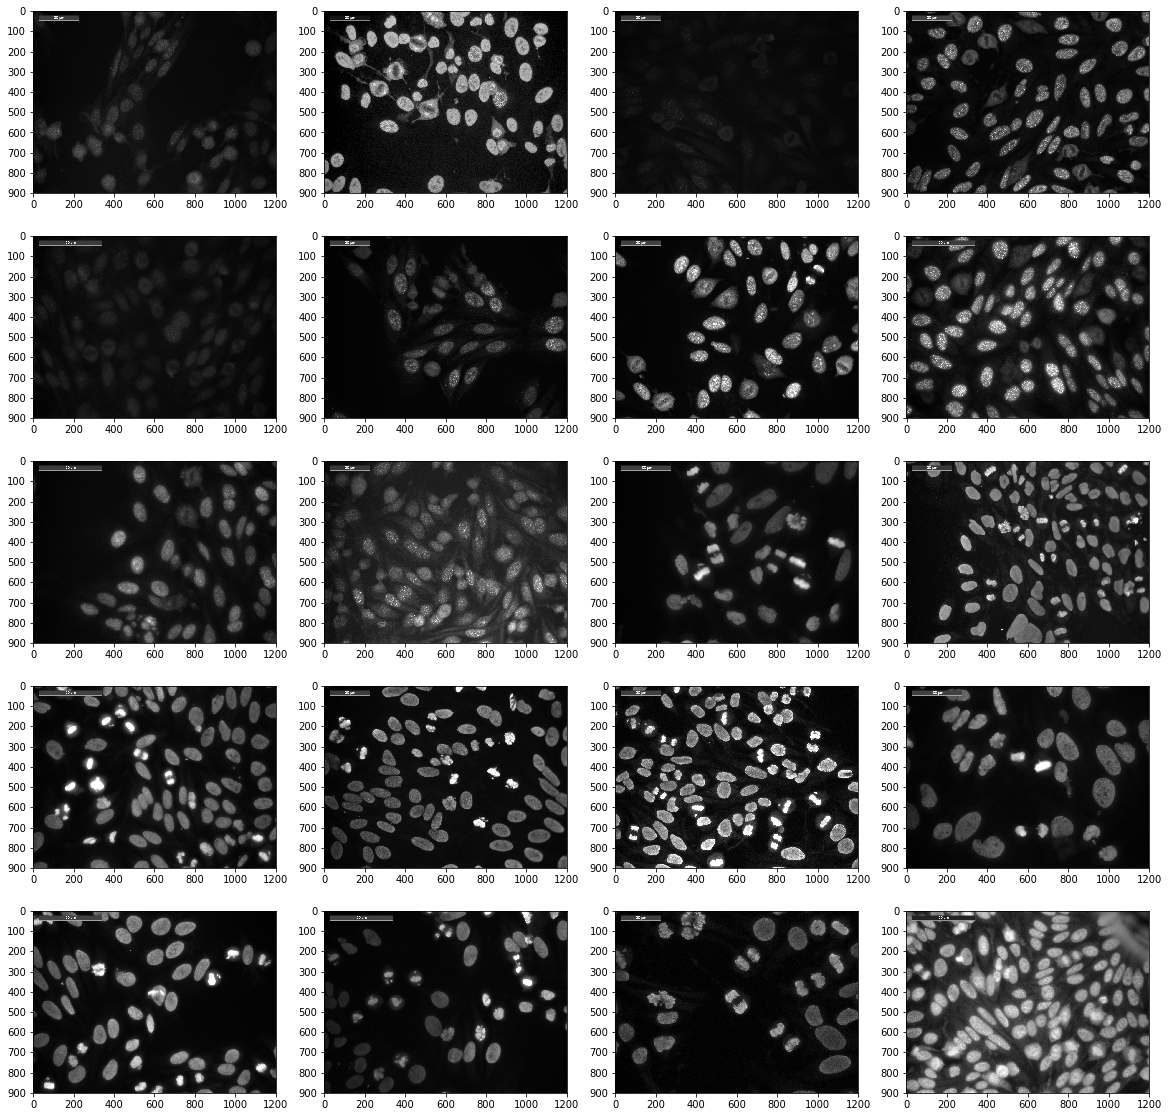

In [177]:
plt.figure(figsize=(20, 20))
grid_plot(samples, 5, 4, 'imshow', cmap='gray')

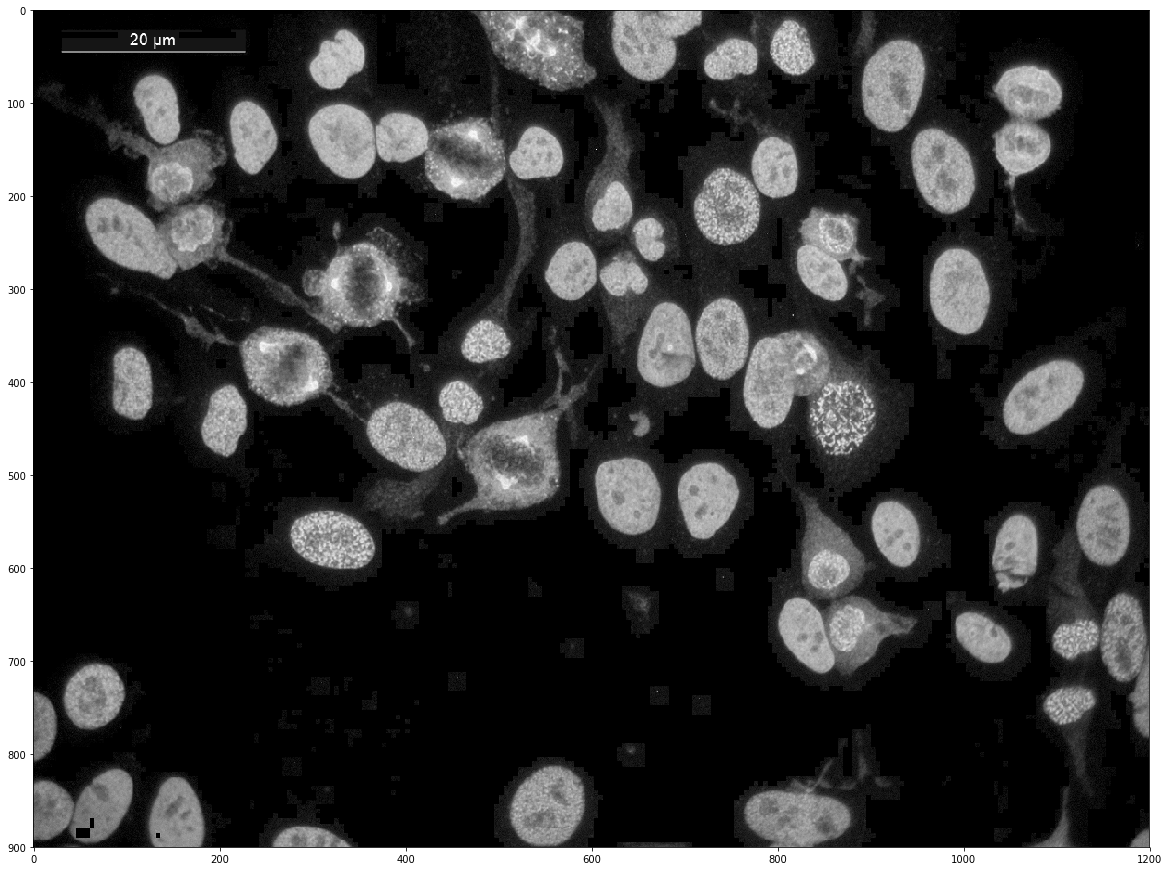

In [241]:
idx = 1
h, w = samples[0].shape
mask_res = resize_binary_mask(std_masks[idx], (w, h))

negate = 0
if negate:
    mask_res = np.logical_not(mask_res)

plt.figure(figsize=(20, 20))
plt.imshow(samples[idx] * mask_res, cmap='gray')

## extract training windows

In [242]:
def get_training_windows(img, mask, neg_threshold, pos_threshold, window_size, stride):
    windowed = to_windowed(img, window_size, stride, flatten=False)
    mask_windowed = to_windowed(mask, window_size, stride, flatten=True)
    mask_means = np.mean(mask_windowed, axis=2)
    
    neg = windowed[mask_means < neg_threshold]
    pos = windowed[mask_means > pos_threshold]
    
    return neg, pos

In [259]:
%%time

idx = 1
sample_img = samples[idx]
sample_mask = resize_binary_mask(std_masks[idx], (sample_img.shape[1], sample_img.shape[0]))

neg_windows, pos_windows = get_training_windows(
    sample_img, sample_mask,
    neg_threshold=0.1,
    pos_threshold = 0.85,
    window_size=224, stride=32
)

print(neg_windows.shape, pos_windows.shape)

(32, 224, 224) (39, 224, 224)
CPU times: user 68.1 ms, sys: 165 ms, total: 233 ms
Wall time: 231 ms


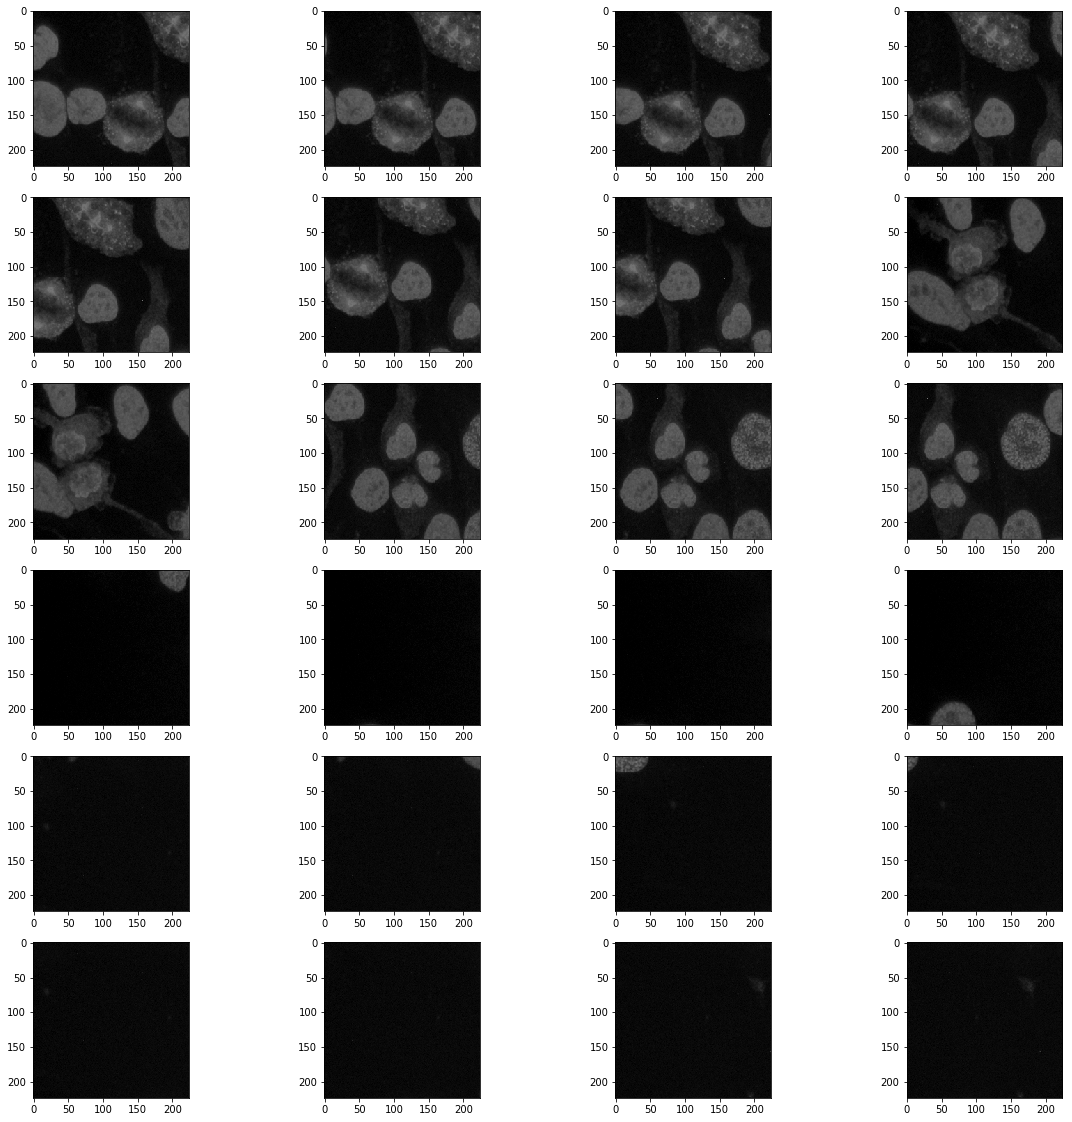

In [260]:
plt.figure(figsize=(20, 20))
grid_plot(np.concatenate([pos_windows[:12], neg_windows[:12]]), 6, 4, 'imshow', cmap='gray', vmin=0, vmax=255)